# Temporally Dependent TV/TGV Regularisation

## Training Script

1. Loading inputs and labels
2. Partitioning in training and validation data 
3. Visualization of a sample
4. Defining the models
5. Loss function and optimizer
6. Training loop
7. Results

In [1]:
# Imports
import sys
import torch
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
sys.path.append("/home/jovyan/P1-Temp-Reg/nns_based_approach")
from cnn_blocks.unet import UNet
from utilities.dataset import ImageDataset, collate_func
from utilities.plot import animated_imshow
from tv_recon_network.network import LearnedTVMapCNN
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# data_path = "/home/jovyan/data/"
data_path = "/home/jovyan/data_2/"
valid_fraction = 0.2

dataset = ImageDataset(input_data_path=f"{data_path}input_data/", 
                       label_data_path=f"{data_path}label_data/")

train_set_len = int((1-valid_fraction)*len(dataset))
dataset_train, dataset_valid = torch.utils.data.random_split(dataset, [train_set_len, len(dataset)-train_set_len])

print(f"Total: {len(dataset)}\nTraining: {len(dataset_train)}\nValidation: {len(dataset_valid)}")

Total: 325
Training: 260
Validation: 65


In [3]:
# Parameters
epochs = 100
n_batch = 1
learning_rate = 1e-4

In [4]:
# Define data loaders
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=n_batch, shuffle=True, collate_fn=collate_func)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=n_batch, shuffle=False, collate_fn=collate_func)

In [5]:
# Test Data Loader

# next(iter(train_loader))

In [6]:
# Visualize the data
data, label, acq_model = dataset_valid[20]
animated_imshow(label[0, ...])

print(label.float())

Started reading acquisitions from /home/jovyan/data_2/input_data/y_49.h5
0%..10%..19%..29%..38%..47%..57%..66%..75%..85%..94%..
Finished reading acquisitions from /home/jovyan/data_2/input_data/y_49.h5
tensor([[[[  7.,   8.,   8.,  ...,  10.,   9.,   9.],
          [  9.,   9.,   9.,  ...,  10.,   9.,  10.],
          [ 10.,  11.,  11.,  ...,  10.,   9.,  10.],
          ...,
          [ 97.,  63.,  76.,  ...,  24.,  25.,  26.],
          [100.,  81.,  62.,  ...,  24.,  26.,  27.],
          [104.,  97.,  70.,  ...,  25.,  25.,  25.]],

         [[  7.,   8.,   8.,  ...,  10.,   9.,   9.],
          [  9.,   9.,   8.,  ...,   9.,   8.,  10.],
          [ 10.,  11.,  11.,  ...,  10.,   9.,  10.],
          ...,
          [117., 109.,  80.,  ...,  25.,  25.,  25.],
          [124., 120.,  93.,  ...,  26.,  27.,  26.],
          [124., 119.,  98.,  ...,  27.,  27.,  26.]]]])


## Data Format

- `data` is a SIRF AcquisitionData object, time and readout dimensions are mixed in array dimension 0 due to call `as_array()`
- `label` is a nifti image
- `model` is a SIRF AcquisitionModel object 

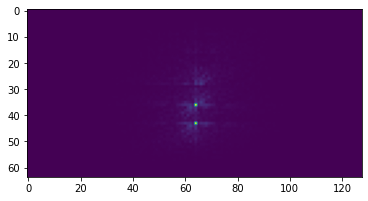

In [7]:
plt.imshow(np.abs(data.as_array()[:, 0, :]))
plt.show()

In [ ]:
# Define the model
unet = UNet(dim=3, 
          n_ch_in=2, 
          n_ch_out=3, 
          n_enc_stages=1,
          n_convs_per_stage=4, 
          n_filters=16,
          kernel_size=3, 
          res_connection=False,
          bias=True).cuda()

# print(unet)

In [ ]:
model = LearnedTVMapCNN(unet, T=1, beta_reg=5.)
# print(tv)

# test, _ = model(data, acq_model)
# test.dtype

In [ ]:
# Loss function
loss_func = torch.nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Define training routine for one batch
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels, acq_model = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs, _ = model(inputs, acq_model)

        # Compute the loss and its gradients
        loss = loss_func(outputs.abs(), labels)
        print(f"IT {i+1}, EPOCH {epoch_index+1}: LOSS={loss}")
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print(f"BATCH {i+1} MEAN LOSS={last_loss}")
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [ ]:
# TRAINING LOOP

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('/home/jovyan/runs/trainer_{}'.format(timestamp))
epoch_number = 0

for epoch in range(epochs):
    print('EPOCH {}:'.format(epoch_number + 1))

    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(valid_loader):
        vinputs, vlabels, v_acq_model = vdata
        voutputs, _ = model(vinputs, v_acq_model)
        vloss = loss_fn(voutputs.abs(), vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    model_path = 'model_{}_{}'.format(timestamp, epoch_number)
    torch.save(model.state_dict(), model_path)

    epoch_number += 1

In [ ]:
next(unet.parameters()).device